In [1]:
!pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable


In [7]:
from lib import evaluate
from lib.serialize import iter_jl
import pandas as pd
import numpy as np

In [8]:
%reload_ext autoreload
%autoreload 2

In [9]:
dict_genres = {'pop': 1, 'country': 2, 'blues': 3, 'rock': 4, 'jazz': 5, "reggae": 6, "hip hop": 7}

In [10]:
df = pd.read_csv('tcc_ceds_music.csv')

In [11]:
df['genre'] = df['genre'].apply(lambda x: dict_genres[x])
df["acousticness"] = np.cbrt(df["acousticness"]) # cube root transform

In [12]:
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,1,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.999330,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,1,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.984707,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,1,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.943674,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,1,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.437839,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,1,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.991902,0.000246,0.597073,0.394375,romantic,1.0


In [13]:
train, test = evaluate.date_split(df)

In [14]:
X_train, y_train = evaluate.x_y_split(train)
X_test, y_test = evaluate.x_y_split(test)

In [15]:
evaluate.to_json_lines(X_train,y_train,'train')
evaluate.to_json_lines(X_test,y_test,'test')

In [16]:
X_train, y_train = iter_jl('X_train.jl'), iter_jl('y_train.jl')

In [17]:
X_test, y_test = iter_jl('X_test.jl'), iter_jl('y_test.jl')

In [18]:
X_train = list(X_train)
y_train = list(y_train)
X_test = list(X_test)
y_test = list(y_test)

In [24]:
from lib.transformers import FeatureProjectionFromJson, TargetEncoder, PretrainedFastTextTransformer, TargetEncodeWithNumericalMean, TargetEncodeWithNumericalMaxOutlier, TargetEncodeWithNumericalMinOutlier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

fields = ['age','violence', 
                            'family/gospel','romantic','obscene','movement/places',
                           'light/visual perceptions','family/spiritual','sadness',
                           'danceability','loudness','acousticness','instrumentalness','valence','energy'] 

#saque algunos numericos: 'dating','like/girls','feelings', 'communication', 'world/life','night/time', 'music', 

features_pipe = make_union(make_pipeline(
        FeatureProjectionFromJson(fields)
    ,SimpleImputer()
    
),
                           #make_pipeline(FeatureProjectionFromJson(['topic']), OneHotEncoder()),
                          make_pipeline(TargetEncodeWithNumericalMean('topic', fields)),
                        
                           make_pipeline(TargetEncodeWithNumericalMean('artist_name', fields)),
                           
                           make_pipeline(PretrainedFastTextTransformer('lyrics_fasttext.bin','lyrics')),
                           
                          )

In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics_multi(y_true, y_pred):
    dicc = {'f1': f1_score(y_true, y_pred, average = 'macro'),
      'precision': precision_score(y_true, y_pred, average = 'macro'),
      'acc': accuracy_score(y_true, y_pred),
      'recall': recall_score(y_true, y_pred, average = 'macro')}
    #print(dicc)
    return(dicc)

In [26]:
import lightgbm as lgb
from pprint import pprint
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from time import time


def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    print(params)
    pipe = make_pipeline(
        features_pipe,
        lgb.LGBMClassifier(random_state=42, class_weight = 'balanced', **params)
    )
    t0 = time()
    pipe.fit(X_train, y_train)
    train_time = time() - t0
    loss=-get_metrics_multi(y_test, pipe.predict(X_test))['f1']
    print(f'loss {loss:.02f}')
    return dict(
        loss=loss,
        tr_loss=-get_metrics_multi(y_train, pipe.predict(X_train))['f1'], 
        params=params,
        train_time=train_time,
        status=STATUS_OK
    )

In [36]:
import numpy as np

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 150, 10),
    'subsample': hp.quniform('subsample', 0.6, 0.9, 0.1),
    'reg_alpha': hp.choice('ra', [0, hp.quniform('reg_alpha', 0.01, 0.1, 0.01)]),
}

trials = Trials()

In [37]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=50, trials=trials)

{'n_estimators': 100, 'reg_alpha': 0, 'subsample': 0.8}                         
loss -0.68                                                                      
{'n_estimators': 100, 'reg_alpha': 0, 'subsample': 0.9}                         
loss -0.68                                                                      
{'n_estimators': 50, 'reg_alpha': 0, 'subsample': 0.6000000000000001}           
loss -0.66                                                                      
{'n_estimators': 110, 'reg_alpha': 0.05, 'subsample': 0.7000000000000001}       
loss -0.67                                                                      
{'n_estimators': 50, 'reg_alpha': 0, 'subsample': 0.9}                          
loss -0.66                                                                      
{'n_estimators': 50, 'reg_alpha': 0, 'subsample': 0.7000000000000001}           
loss -0.66                                                                      
{'n_estimators': 80, 'reg_al

In [38]:
def flatten(doc, pref=''):
    res = {}
    for k, v in doc.items():
        k = f'{pref}.{k}' if pref else k
        if isinstance(v, dict):
            res.update(flatten(v, k))
        else:
            res[k] = v
    return res

In [39]:
import pandas as pd
df = pd.DataFrame(list(map(flatten, [e['result'] for e in trials.trials])))
df.sort_values('loss').head()

,loss,tr_loss,params.n_estimators,params.reg_alpha,params.subsample,train_time,status
24,-0.687876,-0.991361,140,0.0,0.8,9.839622,ok
23,-0.687876,-0.991361,140,0.0,0.8,10.846951,ok
25,-0.687876,-0.991361,140,0.0,0.9,9.855466,ok
27,-0.687876,-0.991361,140,0.0,0.8,10.070519,ok
37,-0.687876,-0.991361,140,0.0,0.8,7.813678,ok


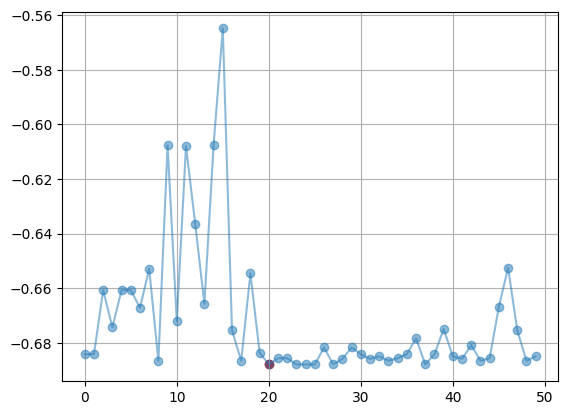

In [40]:
import matplotlib.pyplot as plt

df.loss.plot(style='-o', alpha=0.5)
plt.scatter([df.loss.argmin()], [df.loss.min()], c='r')
# df.tr_loss.plot()
#plt.yscale('log')
plt.grid()

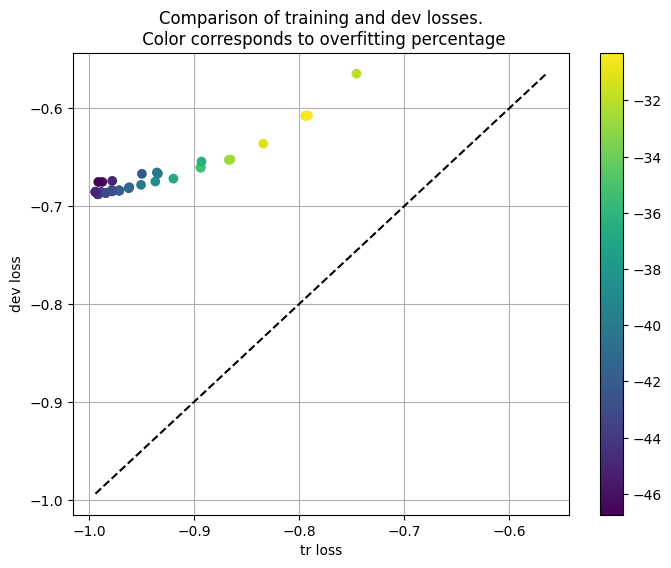

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(df.tr_loss, df.loss, c=(df.loss-df.tr_loss)/df.loss*100)
plt.title('Comparison of training and dev losses.\n Color corresponds to overfitting percentage')
plt.colorbar()
m = min(df.tr_loss.min(), df.loss.min())
M = max(df.tr_loss.max(), df.loss.max())
plt.plot([m, M], [m, M], 'k--')
plt.xlabel('tr loss')
plt.ylabel('dev loss')
plt.grid()

In [42]:
cut_point = df.loss.median()
best_models_df = df[df.loss <= cut_point]
worst_models_df = df[df.loss > cut_point]


def visualize_param(param_name):
  s = df[f'params.{param_name}']
  if s.dtype.name == 'object':
    visualize_categorical_param(param_name)
  else: # assume numerical
    visualize_numerical_param(param_name)

def visualize_categorical_param(param_name):
    pd.concat([
      best_models_df[f'params.{param_name}'].value_counts().rename('best'),
      worst_models_df[f'params.{param_name}'].value_counts().rename('worst')
  ], axis=1).plot.bar()

def visualize_numerical_param(param_name):
  plt.violinplot([
      best_models_df[f'params.{param_name}'],
      worst_models_df[f'params.{param_name}']
  ])
  plt.xticks([1, 2], ['best', 'worst'])

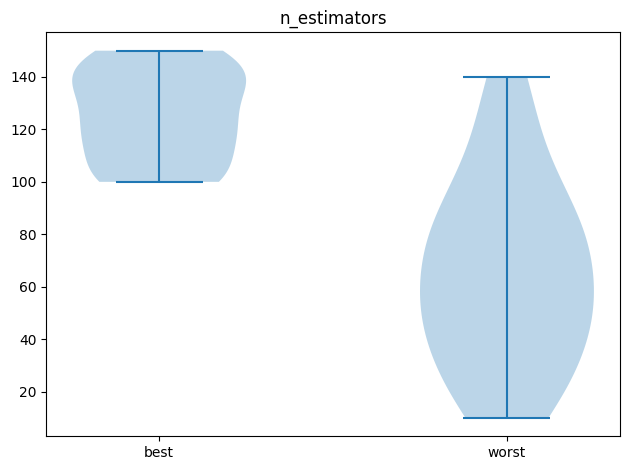

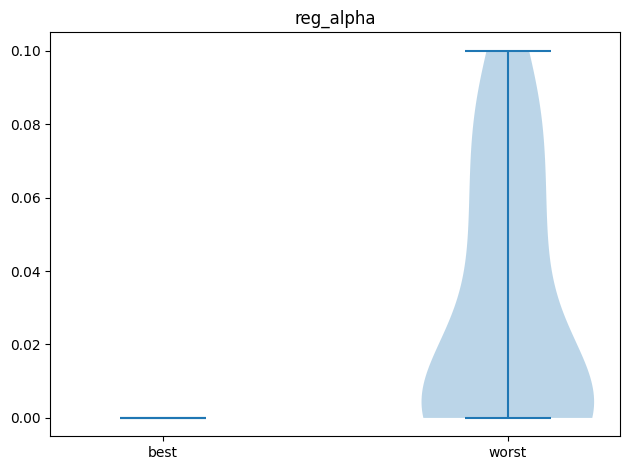

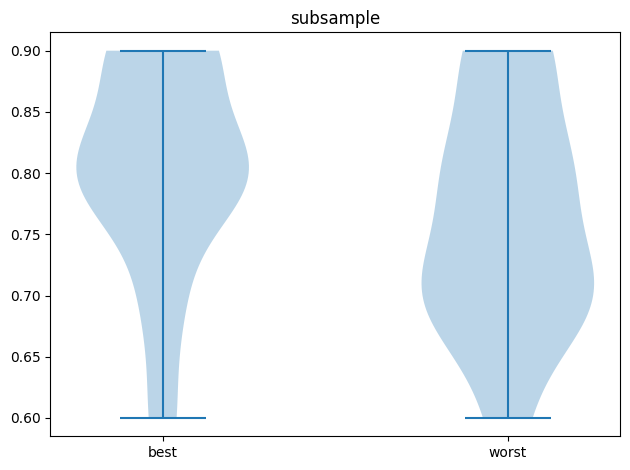

In [43]:

param_names = list(trials.trials[0]['result']['params'].keys())
for param_name in param_names:
  plt.figure()
  visualize_param(param_name)
  plt.title(param_name)
  plt.tight_layout()

In [48]:
# El que menos overfittea de los mejors
best = df[df.loss < df.loss.min() * 0.98].sort_values('tr_loss', ascending=False).head(30)
best

,loss,tr_loss,params.n_estimators,params.reg_alpha,params.subsample,train_time,status
39,-0.674893,-0.936850,70,0.00,0.8,6.657927,ok
36,-0.678306,-0.950392,80,0.00,0.8,5.986866,ok
42,-0.680757,-0.961539,90,0.07,0.8,7.007367,ok
26,-0.681629,-0.962125,90,0.00,0.9,7.635045,ok
29,-0.681629,-0.962125,90,0.00,0.9,6.819544,ok
0,-0.684118,-0.971218,100,0.00,0.8,7.072033,ok
38,-0.684118,-0.971218,100,0.00,0.8,8.019258,ok
35,-0.684118,-0.971218,100,0.00,0.9,7.148907,ok
1,-0.684118,-0.971218,100,0.00,0.9,6.587901,ok
30,-0.684118,-0.971218,100,0.00,0.9,15.169036,ok


In [55]:
params = {k.replace('params.', ''):v for k, v in best.iloc[0].to_dict().items() if 'params.' in k}
rf_pipe = make_pipeline(
    features_pipe,
    lgb.LGBMClassifier(random_state=42, class_weight = 'balanced', **params)
)
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featureprojectionfromjson',
                                                                  FeatureProjectionFromJson(fields=['age',
                                                                                                    'violence',
                                                                                                    'family/gospel',
                                                                                                    'romantic',
                                                                                                    'obscene',
                                                                                                    'movement/places',
                                                                                                    'light/visual '
                                                                                                    'perceptions',
                                                                                                    'family/spiritual',
                                                                                                    'sadness',
                                                                                                    'danceability',
                                                                                                    'loudness',
                                                                                                    'acousticness',
                                                                                                    'instrumentalness',
                                                                                                    'vale...
                                                                                                                  'family/spiritual',
                                                                                                                  'sadness',
                                                                                                                  'danceability',
                                                                                                                  'loudness',
                                                                                                                  'acousticness',
                                                                                                                  'instrumentalness',
                                                                                                                  'valence',
                                                                                                                  'energy']))])),
                                                ('pipeline-4',
                                                 Pipeline(steps=[('pretrainedfasttexttransformer',
                                                                  PretrainedFastTextTransformer(field='lyrics',
                                                                                                fname='lyrics_fasttext.bin'))]))])),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', n_estimators=70,
                                random_state=42, subsample=0.8))])

## Error Analysis

In [59]:
preds = rf_pipe.predict(X_test)

In [60]:
preds

array([1, 5, 1, ..., 7, 7, 1])

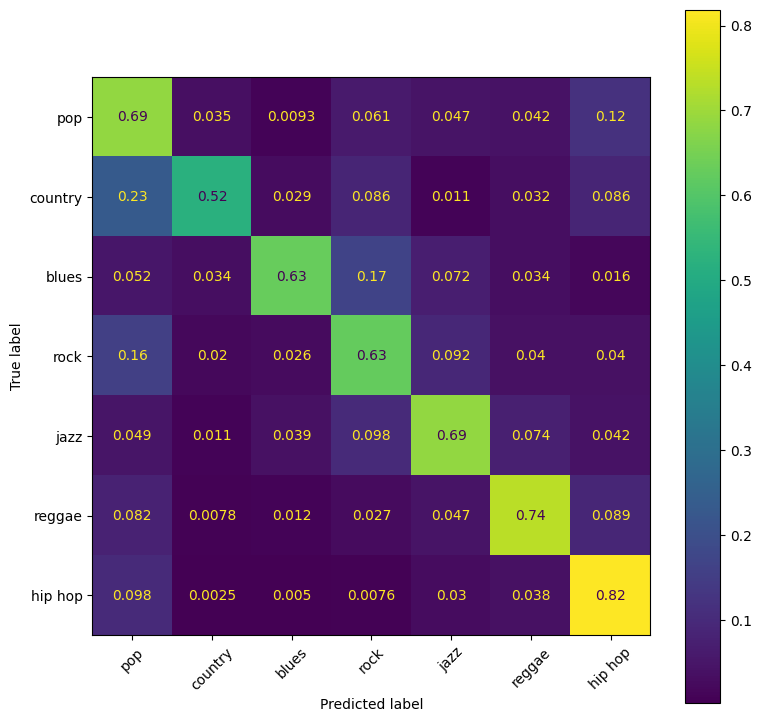

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pylab as plt
fig, ax  = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='true', ax=ax)
ax.xaxis.set_ticklabels(list(dict_genres.keys()))
ax.yaxis.set_ticklabels(list(dict_genres.keys()))
ax.xaxis.set_tick_params(rotation=45)


### Observamos que el blues se confunde mucho con el rock.


### Observamos que country se confunde mucho con pop.

In [65]:
def get_confused_with(trueCategory,predictedCategory, preds, y_test):
    indexes = []
    for i,(pred,true) in enumerate(zip(preds,y_test)):
        if pred == predictedCategory and true == trueCategory:
            indexes.append(i)
    return indexes

In [67]:
test.iloc[get_confused_with(2,1, preds, y_test)]

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
12219,38270,casey donahew,kiss me,2016,2,steppin stone go better play mind silence know...,82,0.000642,0.000642,0.032051,...,0.277001,0.000642,0.564605,0.796452,0.218563,0.000000,0.486810,0.916914,obscene,0.057143
12225,38307,cole swindell,party wasn't over,2016,2,little blue buzz bare foot say hop truck right...,157,0.000381,0.000381,0.000381,...,0.056161,0.072617,0.449800,0.821834,0.410901,0.000000,0.539365,0.909907,obscene,0.057143
12240,38382,ty march.,mr. right now,2016,2,know go like girl felt like watch heart bleed ...,114,0.145822,0.070641,0.038730,...,0.070873,0.048724,0.605762,0.763762,0.663556,0.000000,0.761954,0.807802,obscene,0.057143
12241,38387,jelly roll,when i get rich,2016,2,yeah yeah yeah tell yeah mammy break yesterday...,181,0.030875,0.025906,0.000399,...,0.363573,0.000399,0.458464,0.760480,0.433786,0.000000,0.548640,0.905903,sadness,0.057143
12244,38395,chase bryant,room to breathe,2016,2,girl heart beat chest baby leave bring close l...,18,0.117100,0.003509,0.003509,...,0.548289,0.003509,0.709737,0.791067,0.342164,0.000002,0.799052,0.761754,sadness,0.057143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12471,39627,thomas rhett,remember you young,2019,2,buddies grow straightlaced marry foolin wasn l...,78,0.040221,0.000993,0.498851,...,0.000993,0.065680,0.362071,0.753352,0.709016,0.000000,0.283800,0.510495,world/life,0.014286
12477,39668,jackson michelson,one at a time,2019,2,gonna pick twolane drive fast gear slide gonna...,119,0.000548,0.153828,0.000548,...,0.000548,0.000548,0.683743,0.813527,0.500667,0.000008,0.939200,0.845841,night/time,0.014286
12478,39672,kane brown,live forever,2019,2,life breathin like movie sound turn felt nothi...,77,0.000741,0.000741,0.334113,...,0.000741,0.000741,0.701072,0.704330,0.883553,0.000000,0.333265,0.392373,world/life,0.014286
12479,39674,riley green,in love by now,2019,2,windows roll petty singin tan summer dancin lo...,84,0.000774,0.000774,0.000774,...,0.058974,0.098387,0.560273,0.793349,0.131387,0.000000,0.732069,0.886883,obscene,0.014286


In [92]:
from random import sample
from IPython.display import display_markdown, display
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def display_examples(examples, n, true, predicted):
    
    for a in examples.iterrows():
        ex = a[1]
        #print(ex)
        display_markdown(f"### {ex['track_name']} - {ex['artist_name']} ", raw=True)
        
        for field in fields:
            display_markdown(f"#### {field} ", raw = True)
            display('Actual value: ' + str(ex[field]))
            display('True genre mean value: ' + str(train[train['genre'] == true][field].mean()))
            display('Predicted genre mean value: ' + str(train[train['genre'] == predicted][field].mean()))
    #display(train[train['genre'] == true])

display_examples(test.iloc[get_confused_with(2,1, preds, y_test)],5, 1,2)



### kiss me - casey donahew 

#### age 

'Actual value: 0.0571428571428571'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0006418485954781'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0145717855981009'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.2056894685189913'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3924610867264003'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0006418485780876'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0006418485543197'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0006418485259739'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.2770011232830057'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5646052204050688'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.796451555008589'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.2185634606998226'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.4868095630667766'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.9169143220488968'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### party wasn't over - cole swindell 

#### age 

'Actual value: 0.0571428571428571'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0003813882660763'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0003813883447152'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0750555390037943'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3618878222186694'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0887069782202596'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.1141158102873053'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0003813882690735'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0561606715505741'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.4497996317556592'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.8218342178806758'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.410901399061981'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.5393652102225887'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.9099070961975988'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### mr. right now - ty march. 

#### age 

'Actual value: 0.0571428571428571'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0706410595696631'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0005847953223328'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0005847953872587'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3433045497904482'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0005847953508149'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0005847953378919'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0005847953226462'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0708726030143241'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.6057619408642911'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.76376176191575'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.6635559249679334'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.7619538334707338'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.8078018052215444'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### when i get rich - jelly roll 

#### age 

'Actual value: 0.0571428571428571'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0259057456228407'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0003987241254149'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0203346723312939'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.1837216350277427'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.2189458971489961'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0003987240881278'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0003987240926591'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.3635727712450128'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.4584642044839164'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.760479963079763'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.433785902387755'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.5486397361912614'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.9059029671397144'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### room to breathe - chase bryant 

#### age 

'Actual value: 0.0571428571428571'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0035087720983273'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0788753581736713'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0035087721377659'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0035087721047451'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0035087719638329'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0035087723030462'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0035087719483385'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.5482886795689815'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.7097368136033794'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7910673537932978'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.34216404350511215'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 1.5587044534412957e-06'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.7990519373454246'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.7617543210558726'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### next to me - overtime 

#### age 

'Actual value: 0.0571428571428571'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.3282735946975375'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0003759398571798'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0003759399000915'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0003759398693949'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0664490999538133'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0254649064309614'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0003759398871147'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0463347464213505'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.6122603704104842'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7184062764402738'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.7516692996467772'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.2807089859851608'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.5315169002275146'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### road trippin' - dan + shay 

#### age 

'Actual value: 0.0571428571428571'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0004537205399075'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0195505768144661'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0512148717603719'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3106749024915788'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.2592031401813485'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0004537205387813'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0004537205155773'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0004537205653232'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5234484999458465'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7949388508576263'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.14861135913427656'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.7598928276999175'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.8128069665439001'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### learning - kane brown 

#### age 

'Actual value: 0.0571428571428571'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0639807087067675'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0215315206601612'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0004314064306484'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0420900785565634'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0979856920049553'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0004314063966788'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.000431406405156'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0923035451132376'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.6848261670096395'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7418660103068994'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.7979277800201445'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.6022258862324814'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.5114962549380921'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### from the ground up - dan + shay 

#### age 

'Actual value: 0.0571428571428571'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.3648028971221174'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0650572479744146'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0312523977675778'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0373527760824561'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.127879314221827'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0006835270567626'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0215764934642661'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0006835270403442'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.2375175999133543'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7612234956285413'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.6940562599631498'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.2662819455894476'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.5805674811865995'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### it feels good - drake white 

#### age 

'Actual value: 0.0571428571428571'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0264830818364269'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0006191950890045'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0271489566497373'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.038963668322191'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.1724446927339553'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0118676593107738'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0109693820601819'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0006191951288576'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.7682226795191162'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7908109632592364'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.49798266617704845'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.9773289365210224'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.8518472248582737'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### like you that way - canaan smith 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.000565930967886'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0426688938943159'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0005659310233339'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3347195789415266'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.020902610324102'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0005659309824342'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0005659310135846'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0135361520467906'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.3772338351565038'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.8159372355972617'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.38103213555202503'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.5867683429513602'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.738730578973037'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### a girl is a gun - old dominion 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0676087191360683'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0488891349048579'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.1144418748588546'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3016093083853934'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0005847953673116'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0005847953299735'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0005847953277961'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.11191560141571'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5407776454023612'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.791605773914827'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.6703273945151226'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.9711459192085736'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.9018988380818298'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### memory won't let me - brett young 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0006925208003915'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0006925207874988'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.000692520839257'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0006925207977119'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0006925208178429'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0006925208118806'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0006925207771026'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.484263622194956'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5732697931333262'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7636848447555316'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.19547229806912503'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.4950535861500412'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.7247161272704413'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### on tonight - chase rice 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.000666222552925'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0412340712518211'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0006662225273321'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0006662225396529'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.1551150043391062'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0006662225755358'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0006662225242652'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0006662225535413'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.4855409942597206'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7962720816347459'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.3545722653506675'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.2497938994229183'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.8808771605279363'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### gateway love - thomas rhett 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0006265664282617'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0006265664716189'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0365202998305172'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3241114601917709'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0006265664540965'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0006265664497941'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0171780076238233'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0200206965662872'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.67507852269035'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.73261031202728'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.4134622489672818'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 3.947368421052632e-06'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.5898598516075844'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.5955829651536664'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### grave - thomas rhett 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.4820855440539517'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0531384299609886'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0006418485286917'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0327721620200433'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0006418485502503'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0006418485649251'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.00064184855502'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0006418485363681'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.527780786309975'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.773094377355588'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.35296780770915154'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.5476092333058532'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.6226108362943867'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### billions - russell dickerson 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0007412898557698'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0731540821385415'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0573110575372138'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.4119060962574854'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0007412898921751'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0350789732612135'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0007412898453739'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0007412898740072'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5310300010830717'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7873496910494064'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.42246598815992764'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.5692497938994229'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.7707636114361128'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### hotdamalama - parmalee 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0007209805532531'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0007209805415174'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0007209806223311'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3141311189075131'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.1593994615393091'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0007209805741671'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0007209805386218'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0007209805639342'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5613560056319723'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.815116785888265'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.22860401518617934'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.8124484748557297'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.9239215479001944'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### i miss you bae - seckond chaynce 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0005599104994496'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0005599104172192'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0005599104231812'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0584556008495117'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0005599104316855'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0005599104284688'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0005599104197919'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.057012883128433'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.7227336726957654'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.6998692408276286'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.7278195723242992'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.6723000824402307'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.4674508353013627'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### close enough - brett young 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0007518797436849'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0007518797007348'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.4182891726222014'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0007518797584711'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0007518798046788'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.1548740375186583'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0007518797136305'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0007518797534817'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.4844579226686885'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7779657975027561'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.15610682863201888'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 1.6194331983805669e-06'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.5548227535037098'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.7357274821796236'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### dearly departed - jelly roll 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.1084674072343904'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0004616805442458'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0004616805274573'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3186972855918771'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0689647949142071'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.04876437731742'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0004616805684496'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0004616805471174'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.8028809704321456'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7431992410840191'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.44723725762368216'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.5249381698268754'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.6536428364929915'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### lonely call - raelynn 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0004873294618748'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0004873294390257'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0004873294424758'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0537346057392686'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0004873294846261'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0539669914885791'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0663747791833667'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0935197384862448'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5700205783602297'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.794554265056534'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.40527457451784415'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.2260923330585325'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.722714062741499'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### dirt road dollars - dirt rock empire 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0861461518000605'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0009398496269701'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0009398496337694'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0009398496986861'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0009398496388187'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0009398496611388'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0009398496248482'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0009398496861279'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5765190079064226'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.8004768863933542'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.2360440621438524'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.4332234130255565'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.6866769012205385'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### you broke up with me - walker hayes 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0004616805539584'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0096345867134501'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0204702047068103'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.303454038586029'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0004616805427246'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.00046168056374'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0100702506088548'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.1489558611864677'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.850536120437561'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7017665307796835'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.807792576841728'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.8763396537510306'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.6996903206586632'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### hotel key - old dominion 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.000487329448971'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0132824346744983'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0004873294452031'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.000487329463402'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.2728030709754842'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.1131175967076771'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0004873294420004'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.3830009640760668'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.7541427488356981'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7837858626259517'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.5343928138981859'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.9690849134377576'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.8678637410898117'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### hate goes on - jelly roll 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0004784689394244'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0117905901324256'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.050070512431521'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.7064388958203699'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.00047846893554'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0004784689608297'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0004784689430668'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0004784689413096'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.7303151738329904'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7677101761402969'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.3946042948666535'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.6413849958779883'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.8668627088253406'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### get to you - michael ray 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0545612457768786'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0688132425656272'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0005659309587191'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0005659309711091'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0005659309743935'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0005659309661634'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0005659309609918'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.3640350989990464'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.4595472760749486'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7692228802912595'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.6947503187677654'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.000414979757085'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.1920857378400659'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.5655519972195326'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### this night back - canaan smith 

#### age 

'Actual value: 0.0428571428571428'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0006497726030705'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0384351100257459'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.000649772583385'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.6567211141400483'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0006497726224402'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0006497725896981'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0006497726602329'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0006497725870519'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5689375067691976'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7910673537932978'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.5447385269030586'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.5290601813685079'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.8638596120319272'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### missing one - jameson rodgers 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0868732367630425'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.037908020624463'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0006662226420697'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.170765421118468'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0006662225699471'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0006662225417469'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.000666222570237'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0698714938252231'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5765190079064226'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7957849396200292'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.4812307694473702'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 1.811740890688259e-05'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.2951360263808739'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.689679998013952'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### wings of an angel - lauren alaina 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0006341154559859'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0006341154335985'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0006341154460423'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0006341154360614'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.000634115445169'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.418190198070756'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0510226324365041'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.3088494486103266'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.591682010180873'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7727097915544957'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.7414616395364945'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.5517312448474855'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.6186067072365022'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### river rat - upchurch 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.3354148166916467'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0555604518104918'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0006119951248368'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.2201601916778883'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.2582167772157723'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0006119951601541'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0006119951376112'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.000611995120273'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.8613668363478827'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7968617798630874'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.2966419590159672'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.4414674361088211'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.722714062741499'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### diesel gang - katie noel 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.1379732111617549'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0241065762092096'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0006265664201158'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3008786564081523'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.2170035940254409'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0006265664933684'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0006265664583128'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0006265664667512'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.961009422722842'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.658616003897136'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.5085531624700133'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.4260098928277001'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.5395251583432836'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### graveyard - kelsea ballerini 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.1731636218987534'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0333489240393657'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0004460303386071'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0004460303497796'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.1443733953434563'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0004460303437939'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0369001760983611'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.3576328847137615'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.52019928517275'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7427377381227085'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.5806634551032186'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 3.61336032388664e-06'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.3971558120362737'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.7487409016177482'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### things that we drink to - morgan evans 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0005316321434929'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0184084603541692'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0005316321184678'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0336193864283883'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.2859683026280817'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0387332546802767'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0005316321271411'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0791599282157803'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.539694573811329'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7049201343486398'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.3111353034989789'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 2.348178137651821e-06'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.2673124484748557'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.5325179324919858'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### cardboard heart - thomas rhett 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0009398496827868'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0009398496691423'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0009398497022632'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0009398496795935'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.1542573080112216'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0009398496626184'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0009398496788251'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.3800780083025183'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.6739954510993178'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7854011229905391'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.23113744044660925'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.8371805441055234'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.7867801276676507'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### fun and games - kelsea ballerini 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.000548245632381'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0005482456160231'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0883976922649767'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3291512998164488'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0005482456404475'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.000548245631142'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0005482456214372'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.1290184267130441'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.6534170908697066'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7608645488808552'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.47685566232944987'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.598103874690849'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.7327243853862102'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### what we gonna do about it - cale dodds 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0004017677893713'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0579239385860362'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0004017677815888'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3515259182102535'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0004017678117241'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0611844831051569'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0004017677938521'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0004017677909768'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5375284306292646'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7972720047175857'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.47685566232944987'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.7124896949711458'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.7677605146426995'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### man in the mirror - russell dickerson 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0356372357486985'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0003654970775208'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0003654970826611'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0003654971046129'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.047685456847866'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0003654971000528'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0003654971077007'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0576488230719465'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.7703888227011806'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.705304720149732'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.8184226655492685'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 2.0951417004048586e-06'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.3208985985160759'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.5565427068392926'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### catch - brett young 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0004017677963977'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0156513095307243'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0004017678063858'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.4167605051329403'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.1793445616009148'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0004017678129671'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0004017677798851'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.2633367592282289'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5461930033575221'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7517370458682664'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.29200598667951866'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.598103874690849'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.7657584501137572'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### chapters - brett young 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0005316321390666'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.017616963262451'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.1152390522869911'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.1633229099005253'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0005316321385218'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0005316321332396'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0118360695436167'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0005316321363557'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5711036499512618'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7394559392867215'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.5643266596074786'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.6382934872217642'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.6136015459141466'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### here tonight - brett young 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0005263158130735'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0144551525565439'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.1561858638434712'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0005263158175601'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0005263158044082'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.1210496310232596'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.000526315802285'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0387030007281975'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.4931224953969457'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7790682767992205'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.24360777385453786'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.4373454245671888'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.7767698050229395'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### change your name - brett young 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0006925208374733'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.012167794677982'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0371360291632115'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0006925208184859'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.1097034181162013'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0216645346420297'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0006925207763135'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0866271350030022'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5613560056319723'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7095095249083403'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.7227297450948345'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.3837592745259687'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.5815685134510706'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### heart's having a hard time - filmore 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0005211047600561'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.016167061509346'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.06164885006992'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0005211047625615'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0005211047605184'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0005211047475415'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0005211047467335'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.3315439228995491'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.4682118488032059'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7850678152962591'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.3218266713196791'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.271434460016488'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.6306190944101557'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### million reasons - dan + shay 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0004741584021403'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.047305630545651'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0004741583716027'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0004741584055558'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.070623940548933'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0004741583799653'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0004741583704845'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0748976669647309'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5776020794974548'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7490193062072148'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.3185623848126093'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.1992992580379225'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.542528255136697'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### change my life - levi hummon 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0005425936161061'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0005425936536501'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.1014671124786223'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0415927013823178'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.2753518866129873'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0005425936118359'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0005425936023394'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0005425936076897'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.7194844579226687'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7665820577904263'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.575657460665784'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.8413025556471557'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.729721288592797'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### rules of breaking up - brandon ratcliff 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0582335078267337'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0004741584074255'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.1550322198116236'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0004741584003673'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0216210971662862'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0004741584008306'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0004741583975729'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.353500184047787'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.6328387306400952'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.8209112119580545'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.5378856993702614'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.7753503709810387'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.7587512242624593'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### stupid love - dan + shay 

#### age 

'Actual value: 0.0285714285714285'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0235029178693306'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.1285704600126015'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0007855461193695'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3192580822094515'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0512731313557438'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.1383841503901488'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0007855460107511'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.000785545996988'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.6794108090544786'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.8038612414429659'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.5111281786486316'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.7300082440230832'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.5455313519301104'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### feels like a party - locash 

#### age 

'Actual value: 0.0142857142857142'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0003957261804418'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0003957261637804'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0003957261887597'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.4179300744631443'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.1940621640332547'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.000395726165936'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0003957261782088'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0003957261712875'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5321130726741038'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.786247211752942'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.38172242517411475'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.7537098103874691'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.8798761282634652'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### family tree - caylee hammack 

#### age 

'Actual value: 0.0142857142857142'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0004873294557675'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.1007240092658711'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0004873294374336'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3434731520285855'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0956493963698743'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0725249111297978'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.1226084147920494'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0004873294584169'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.67507852269035'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7959900520472784'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.2485810667594558'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0021356275303643'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.531121187139324'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.8548503216516872'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### same asshole - jelly roll 

#### age 

'Actual value: 0.0142857142857142'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0003869969261006'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0369883037234778'

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### remember you young - thomas rhett 

#### age 

'Actual value: 0.0142857142857142'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0009930486716643'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0198990602378375'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0009930486954496'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0659562262998511'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0665554139514345'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.000993048788061'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0854494231457438'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0009930487396989'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.3620708328820535'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7533523062328538'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.709016065259874'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.283800494641385'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.510495222673621'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### one at a time - jackson michelson 

#### age 

'Actual value: 0.0142857142857142'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.1538276826843091'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0005482456215704'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0192820774816805'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0330035671215668'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.000548245655135'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0655811242810259'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0005482456177301'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0005482456402548'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.6837430954186072'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.8135271645770837'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.5006672824337695'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 7.904858299595141e-06'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.9392003297609234'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.845841031271447'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### live forever - kane brown 

#### age 

'Actual value: 0.0142857142857142'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.000741289919275'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0007412898626882'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0933561044160168'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.1994329523999649'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0007412899167186'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0007412899018382'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0007412899015556'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0007412898651787'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.701072240875122'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7043304361202984'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.883552582983683'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.3332646331409728'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.3923734154660285'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### in love by now - riley green 

#### age 

'Actual value: 0.0142857142857142'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.0007739938365267'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.000773993814441'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.0007739938345334'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.3387619036407747'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.0007739938558599'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0007739938400309'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0007739938080496'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.0589739583146687'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.5602729340409401'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.793349229546445'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.13138701406054304'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.7320692497938994'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.8868833541147629'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'

### puzzle of us - adam doleac 

#### age 

'Actual value: 0.0142857142857142'

'True genre mean value: 0.4796850359681147'

'Predicted genre mean value: 0.509043656169648'

#### violence 

'Actual value: 0.3080601605532571'

'True genre mean value: 0.10656361423223608'

'Predicted genre mean value: 0.07363546930947919'

#### family/gospel 

'Actual value: 0.0008097166026168'

'True genre mean value: 0.01505173259582355'

'Predicted genre mean value: 0.020190124970601107'

#### romantic 

'Actual value: 0.2397737707689569'

'True genre mean value: 0.05323556612950804'

'Predicted genre mean value: 0.058995075712256505'

#### obscene 

'Actual value: 0.0008097166353004'

'True genre mean value: 0.08675332305192099'

'Predicted genre mean value: 0.06163003474064094'

#### movement/places 

'Actual value: 0.206830331758707'

'True genre mean value: 0.041575811764612905'

'Predicted genre mean value: 0.0657869691158579'

#### light/visual perceptions 

'Actual value: 0.0008097166684402'

'True genre mean value: 0.049387914261266305'

'Predicted genre mean value: 0.04834902428074018'

#### family/spiritual 

'Actual value: 0.0008097166461293'

'True genre mean value: 0.02064314666002228'

'Predicted genre mean value: 0.021578577853411312'

#### sadness 

'Actual value: 0.000809716665238'

'True genre mean value: 0.1446821592993433'

'Predicted genre mean value: 0.16914635864133712'

#### danceability 

'Actual value: 0.617675728365645'

'True genre mean value: 0.5170001868228888'

'Predicted genre mean value: 0.53834445495748'

#### loudness 

'Actual value: 0.7345588800861471'

'True genre mean value: 0.6795645334140663'

'Predicted genre mean value: 0.6279140140083709'

#### acousticness 

'Actual value: 0.5980069353231316'

'True genre mean value: 0.5529355208244603'

'Predicted genre mean value: 0.7153208929863482'

#### instrumentalness 

'Actual value: 0.0'

'True genre mean value: 0.048690262945149734'

'Predicted genre mean value: 0.01886357910956246'

#### valence 

'Actual value: 0.1601401483924154'

'True genre mean value: 0.5396623310227712'

'Predicted genre mean value: 0.5344355891620532'

#### energy 

'Actual value: 0.542528255136697'

'True genre mean value: 0.6009371783887157'

'Predicted genre mean value: 0.4545832407104352'